# Performance Testing

## Setup
This cell must be run prior to the others. Modify `visualise` depending on your needs.

In [2]:
from src.agent import Agent
from src.env import MultipleOvercookedEnv, OvercookedEnvFactory
from src.parameters import Hyperparameters, Options
from src.testing import AgentTester
from src.training import AgentTrainer, ParallelAgentTrainer
from src.utils import create_writer, plot_rewards, run_tensorboard

# This cell is needed for all other cells
factory = OvercookedEnvFactory(info_level=0, horizon=400, old_dynamics=True)
visualise = False
# If set to true, games will be visualised via Pygame
# If set to false, a short description will instead be printed about played games.
# Be wary that due to some issues in Jupyter Notebook, 
# pygame windows will stay open forever unless you close them manually

## Cramped Room Performance

In [ ]:
forced_coordination = factory.create_env("cramped_room")

options = Options(
    save_agent_after_training=True, 
    tqdm_description="Cramped Room",
    checkpoints_dirname="cramped_room_first",
    total_episodes=1000
)
parameters = Hyperparameters()
cramped_room_agent = Agent(
    parameters=parameters,
    options=options,
    n_actions=forced_coordination.action_space.n,
    input_dim=forced_coordination.observation_space.shape,
    writer_factory=lambda: create_writer(name="Cramped Room Agent")
)
cramped_room_agent.load_if_save_exists()

In [ ]:
if not cramped_room_agent.loaded_from_save:
    cramped_room_trainer = AgentTrainer(forced_coordination, cramped_room_agent)
    cramped_room_trainer.train_agent()
    run_tensorboard()
else:
    print("Agent has already been trained.")

In [ ]:
tester = AgentTester(forced_coordination, cramped_room_agent)
game = tester.play_game()
game.visualise_or_report(visualise=visualise)

## Overfitting in Cramped Room
This is demonstrated by not using minibatches and penalising the agent less for being deterministic.

In [ ]:
for is_overfitted in (True, False):
    forced_coordination = factory.create_env("cramped_room")
    if is_overfitted:
        parameters = Hyperparameters(entropy_coefficient=0.001, batch_size=4000)
    else:
        parameters = Hyperparameters()

    overfit_options = Options(
        rollout_episodes=10, 
        total_episodes=1000,
        use_batches=not is_overfitted,
        save_agent_after_training=True,
        checkpoints_dirname=f"{'non' if not is_overfitted else ''}overfit_cramped_room",
        tqdm_description="Overfit Agent" if is_overfitted else "Non-overfit agent",
    )
    overfit_agent = Agent(
        parameters=parameters, 
        options=overfit_options, 
        env=forced_coordination,
        writer_factory=lambda: create_writer(
            name="Overfitted Cramped Room" if is_overfitted else "Non-overfitted Cramped Room"
        )
    )
    overfit_agent.load_if_save_exists()

    if not overfit_agent.loaded_from_save:
        overfit_trainer = AgentTrainer(forced_coordination, overfit_agent)
        overfit_trainer.train_agent()
    else:
        print("Agent was already trained.")

    tester = AgentTester(
    forced_coordination, 
        overfit_agent, 
        always_choose_best_actions=is_overfitted
    )
    game = tester.play_game()
    game.visualise_or_report(visualise=False)
run_tensorboard()

Overfit Agent:   0%|          | 0/1000 [00:00<?, ?step/s]

Saved actor and critic to /Users/luca/Unibo/92858/aas-overcooked-ai/checkpoints/overfit_cramped_room
On cramped_room, the agents earned a total reward of 0 and made 0 soups


Non-overfit agent:   0%|          | 0/1000 [00:00<?, ?step/s]

Saved actor and critic to /Users/luca/Unibo/92858/aas-overcooked-ai/checkpoints/nonoverfit_cramped_room
On cramped_room, the agents earned a total reward of 140 and made 7 soups


Running TensorBoard...
E0606 20:57:43.282732 8529233984 program.py:300] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use


In [ ]:
tester = AgentTester(
    forced_coordination, 
    overfit_agent, 
    always_choose_best_actions=True
)
game = tester.play_game()
game.visualise_or_report(visualise=visualise)

## Multiple Environments

In [6]:
multi_env = MultipleOvercookedEnv("forced_coordination", "forced_coordination", "asymmetric_advantages")

options = Options(
    save_agent_after_training=True, 
    checkpoints_dirname="multi_envs",
    total_episodes=1000
)

multi_env_agent = Agent(
    parameters=Hyperparameters(), 
    options=options, 
    env=multi_env,
    writer_factory=lambda: create_writer(name="Multiple Envs")
)
multi_env_agent.load_if_save_exists()

if not multi_env_agent.loaded_from_save: 
    trainer = AgentTrainer(multi_env, multi_env_agent)
    trainer.train_agent()
else:
    print("Agent was already saved.")

Forced Coordination:   0%|          | 0/1000 [00:00<?, ?step/s]

Saved actor and critic to /Users/luca/Unibo/92858/aas-overcooked-ai/checkpoints/multi_envs


In [11]:
for env in multi_env:
    multi_env_tester = AgentTester(env, multi_env_agent)
    game = multi_env_tester.play_game()
    game.visualise_or_report(visualise=visualise)

On forced_coordination, the agents earned a total reward of 0 and made 0 soups
On forced_coordination, the agents earned a total reward of 0 and made 0 soups
On asymmetric_advantages, the agents earned a total reward of 240 and made 12 soups


## Removing vs keeping shaped rewards

In [ ]:
parameters = Hyperparameters()
# Because we are using subprocesses
options = Options(is_running_jupyter_notebook=False)

trainer = ParallelAgentTrainer(
    "forced_coordination",
    "forced_coordination", 
    parameters=Hyperparameters(),
    options=[
        options.with_values(tqdm_description="Always shaped"), 
        options.with_values(tqdm_description="Stop shaped")
    ]
)

trainer.train_agents()
trainer.wait_until_finished_training()
run_tensorboard()

## All layout results

Asymmetric Advantages:   0%|          | 0/1000 [00:00<?, ?step/s]

Coordination Ring:   0%|          | 0/1000 [00:00<?, ?step/s]

Counter Circuit O 1Order:   0%|          | 0/1000 [00:00<?, ?step/s]

Cramped Room:   0%|          | 0/1000 [00:00<?, ?step/s]

Forced Coordination:   0%|          | 0/1000 [00:00<?, ?step/s]

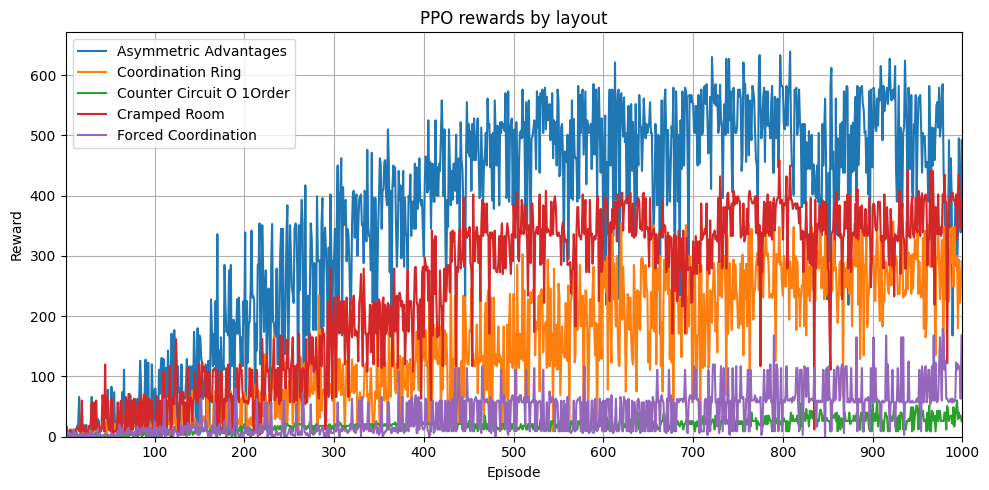

In [ ]:
from src.dtypes import LayoutName, Reward
from src.utils import get_proper_layout_name

layout_names: list[LayoutName] = [
    "asymmetric_advantages", 
    "coordination_ring", 
    "counter_circuit_o_1order", 
    "cramped_room", 
    "forced_coordination"
]

# Results will vary depending on this value (also as shown in the report)
critic_fc_dim = 192
options = Options( 
    save_agent_after_training=False, 
    total_episodes=1000
)
parameters = Hyperparameters(
    critic_fc1_dim=critic_fc_dim,
    critic_fc2_dim=critic_fc_dim
)

rewards_and_layouts: list[tuple[LayoutName, list[Reward]]] = []

for layout_name in layout_names:
    layout_proper_name = get_proper_layout_name(layout_name)
    options = options.with_values(
        tqdm_description=layout_proper_name
    )

    env = factory.create_env(layout_name)
    agent = Agent(
        parameters=parameters,
        options=options, 
        env=env,
        writer_factory=lambda: create_writer(name=layout_proper_name)
    )

    trainer = AgentTrainer(env, agent)
    rewards = trainer.train_agent()
    rewards_and_layouts.append((layout_name, rewards))

plot_rewards(rewards_and_layouts)

## Generalisation capabilities with 2 different environments

In [9]:
coordination_ring, forced_coordination = factory.create_envs("coordination_ring", "forced_coordination")
options = Options(
    save_agent_after_training=False,
    checkpoints_dirname="two_env_generalisation",
    total_episodes=2000
)
parameters = Hyperparameters()
agent = Agent(
    parameters=parameters,
    options=options, 
    env=coordination_ring
)
agent.load_if_save_exists()

multi_env = MultipleOvercookedEnv(coordination_ring, forced_coordination, reset_env_interval=1)
if not agent.loaded_from_save:
    trainer = AgentTrainer(multi_env, agent)
    trainer.train_agent()

for env in multi_env:
    tester = AgentTester(env, agent)
    game = tester.play_game()
    game.visualise_or_report(visualise=False)

Coordination Ring:   0%|          | 0/2000 [00:00<?, ?step/s]

On coordination_ring, the agents earned a total reward of 0 and made 0 soups
On forced_coordination, the agents earned a total reward of 0 and made 0 soups


## Using larger critic dimensions

Asymmetric Advantages:   0%|          | 0/1000 [00:00<?, ?step/s]

Asymmetric Advantages (Modified):   0%|          | 0/1000 [00:00<?, ?step/s]

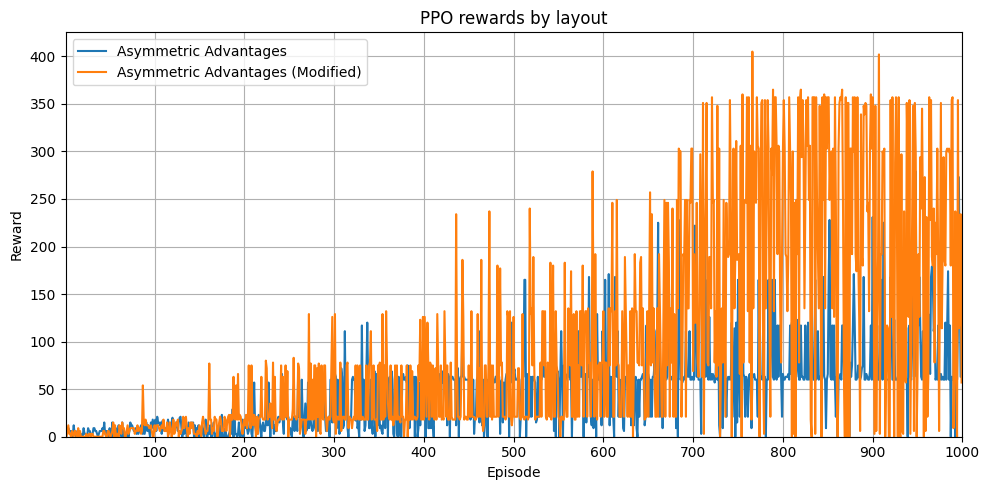

In [ ]:
from src.utils import get_proper_layout_name

# Change the layout name to see the difference in results
layout_name: LayoutName = "asymmetric_advantages"
rewards_and_layouts = []
for name, factor in zip(
    [layout_name, f"{layout_name}_(modified)"],
    (1, 2)
):
    env = factory.create_env("forced_coordination")
    parameters = Hyperparameters(
        critic_fc1_dim=96 * factor,
        critic_fc2_dim=96 * factor
    )
    options = Options(
        tqdm_description=get_proper_layout_name(name), 
        total_episodes=1000,
        is_running_jupyter_notebook=False
    )
    agent = Agent(options=options, parameters=parameters, env=env)
    trainer = AgentTrainer(env, agent)
    rewards = trainer.train_agent()
    rewards_and_layouts.append((name, rewards))

plot_rewards(rewards_and_layouts)

## Batching vs. No batching

In [15]:
for is_batched in (True, False):
    forced_coordination = factory.create_env("forced_coordination")
    parameters = Hyperparameters()

    options = Options(
        rollout_episodes=10, 
        total_episodes=1000,
        use_batches=is_batched,
        save_agent_after_training=True,
        checkpoints_dirname=f"{'non' if not is_batched else ''}batched_forced_coordination",
        tqdm_description="Batched" if is_batched else "Non-batched",
    )
    agent = Agent(
        parameters=parameters, 
        options=options, 
        env=forced_coordination,
        writer_factory=lambda: create_writer(
            name="Batched Forced Coordination" if is_batched else "Non-batched Forced Coordination"
        )
    )
    agent.load_if_save_exists()

    if not agent.loaded_from_save:
        overfit_trainer = AgentTrainer(forced_coordination, agent)
        overfit_trainer.train_agent()
    else:
        print("Agent was already trained.")

    tester = AgentTester(forced_coordination, agent)
    game = tester.play_game()
    game.visualise_or_report(visualise=False)

Batched:   0%|          | 0/1000 [00:00<?, ?step/s]

Saved actor and critic to /Users/luca/Unibo/92858/aas-overcooked-ai/checkpoints/batched_forced_coordination
On forced_coordination, the agents earned a total reward of 0 and made 0 soups


Non-batched:   0%|          | 0/1000 [00:00<?, ?step/s]

Saved actor and critic to /Users/luca/Unibo/92858/aas-overcooked-ai/checkpoints/nonbatched_forced_coordination
On forced_coordination, the agents earned a total reward of 60 and made 3 soups
